In [1]:
import os
import numpy as np
import pandas as pd
import time
import scanpy as sc
import torch

import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

import sys
sys.path.append('../../')
import scDualGN
sys.path.append('../')
import expri_helper

/jdfssz1/ST_HEALTH/P18Z10200N0124/AI/user/baiyong/anaconda3/envs/mytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load data
dat_path = expri_helper.get_path('balasubramanian', dat_ls_file='../expri_data.json')
adata = sc.read_h5ad(dat_path)

In [3]:
n_cluster = len(np.unique(adata.obs['celltype']))

In [4]:
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata,max_value=10)

In [5]:
adata.obs['celltype_str'] = adata.obs['celltype']
adata.obs['celltype'].cat.categories = list(range(0,n_cluster))

In [6]:
start = time.time()
scdualgn_model = scDualGN.scDualGN(adata, n_z=32,device='cuda:2').pretrain(alpha=0.05, beta=20, gamma=4)
scdualgn_model.cluster(n_cluster=n_cluster,eta=1, nu=1, batch_size=1024*2, n_epochs=30)
end = time.time()

print('running time = {}'.format(end-start))


INFO:scDualGN.run:dual-VAE pretrain start...
INFO:scDualGN.run:Epoch 1/100,Overall loss:27124.9403,MSE:1331.5016,MSE1:123.5138,KL: 17.0759
INFO:scDualGN.run:Epoch 2/100,Overall loss:22207.6725,MSE:1106.5595,MSE1:18.6697,KL: 36.0915
INFO:scDualGN.run:Epoch 3/100,Overall loss:21361.8073,MSE:1066.3349,MSE1:8.1484,KL: 50.3127
INFO:scDualGN.run:Epoch 4/100,Overall loss:21078.3191,MSE:1052.7408,MSE1:5.1476,KL: 58.2776
INFO:scDualGN.run:Epoch 5/100,Overall loss:20866.4485,MSE:1042.3089,MSE1:4.2935,KL: 61.9034
INFO:scDualGN.run:Epoch 6/100,Overall loss:20668.3748,MSE:1032.4588,MSE1:3.9998,KL: 64.0083
INFO:scDualGN.run:Epoch 7/100,Overall loss:20520.1171,MSE:1025.0637,MSE1:3.8936,KL: 65.3682
INFO:scDualGN.run:Epoch 8/100,Overall loss:20400.8030,MSE:1019.1288,MSE1:3.7291,KL: 66.2095
INFO:scDualGN.run:Epoch 9/100,Overall loss:20349.4174,MSE:1016.5714,MSE1:3.6615,KL: 66.8820
INFO:scDualGN.run:Epoch 10/100,Overall loss:20332.1837,MSE:1015.7204,MSE1:3.6056,KL: 67.0549
INFO:scDualGN.run:Epoch 11/100,

running time = 37.90345001220703


In [7]:
adata.obs['celltype_scDualGN']=scdualgn_model.y_pred_label
adata.obs['celltype_scDualGN'] = adata.obs['celltype_scDualGN'].astype('category')
adata.obs['celltype'] = adata.obs['celltype']
adata.obsm['X_z']=scdualgn_model.z

sc.pp.neighbors(adata,n_neighbors=20,use_rep="X_z") 
sc.tl.umap(adata)


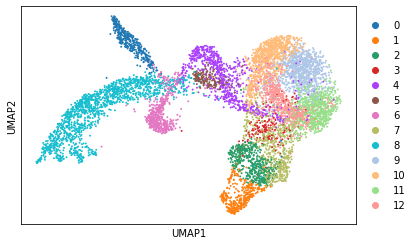

In [8]:
sc.pl.umap(adata, color=['celltype'],title='')

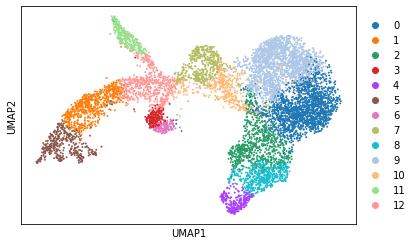

In [9]:
sc.pl.umap(adata, color=['celltype_scDualGN'],title='')